# Demonstration of Reinforcement Learning with Keras

The other night, I was given a problem:

> Two people are playing a game. Player 1 flips a coin, and gets a point if it's heads. Then Player 2 decides to flip any number of coins, and gets two to the power of that number of coins minus one  (2<sup>`(n_coins-1)`</sup>) points. The players take turns performing these actions, and the game ends when either player has at least 100 points. What is the probability that player 2 wins with an optimal strategy?

If Player 2 flipped one coin each time, he would have a slightly less than 50% chance of winning, since he is going second, but otherwise in the same position as the first player. If he flipped 8 coins at a time, then the probability would be slightly higher (there is a 32% chance that Player 2 would win before player 1 could theoretically win and a ~54% chance that player 2 would win by the Player 1's average win time).

Although this is meant to be a statistics problem, I thought this could be a simple example that could be used to demonstrate how to use reinforcement learning and Keras to solve these problems.

## What is Reinforcement Learning?

Reinforcement learning is a way of using machine learning to optimize a result through repetitive simulation/testing. In this case, the training data is a vector-representation of each turn/move that is made by player 2, and the output (result to be optimized) is whether or not the player won that game. 

## What is Keras?

Keras is a neural network library in Python that uses TensorFlow or (to be deprecated) Theano as a backend. It is fairly easy to understand visually, and it is very useful when you don't need very fine control over your neural networks.

## Machi Koro Example

This past summer I implemented a Keras-based neural network for the board game Machi Koro. 

* [first post](http://maxcandocia.com/article/2017/Jul/22/using-neural-networks-to-play-board-games/), which focuses more on the general way the code works

* [second post](http://maxcandocia.com/article/2017/Jul/30/using-ai-for-machi-koro-strategy/), which dives in to the strategy more by looking at the results of simulations from trained data

# Full Code and Explanation

Below I have fully functioning code that uses Keras and reinforcement learning to solve the above problem. I put the neural network code into the `AI` class, and I put most of the game logic code in the `Game` class, with the exception of a few helper functions.

## "Temperature"

When I perform reinforcement learning tasks, I usually try to let the computer make more random decisions early on, and then when the neural network is more trained, I want it to prioritize the better decisions, i.e., the ones that have a higher probability of resulting in winning. For *this specific problem*, I randomize the decision of player 2 when initially training, and then slowly make it less random over time by decreasing a "temperature" parameter that affects the decision the player makes. In the final iterations, I remove all randomness to allow it to more or less settle on a particular strategy.

In [1]:
from random import random, seed
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import SGD
from keras.layers import Dense, Activation
import numpy as np

Using TensorFlow backend.


In [2]:
class AI(object):
    """
    this object contains the neural network formed by Keras and TensorFlow
    it does a bit of transforming of input for training and predictions, as
    well as storing some data of its own, but that's it
    """
    def __init__(self):
        self.initialize_network()
        #stores vector representations of the game states
        self.history = []
        #stores 1s and 0s corresponding to whether player 2 won the game or not
        #in the rows from self.history
        self.win_history = []
        
    def initialize_network(self):
        """
        The network consists of:
        * an input layer (2 variables to describe the scores of each player, 
                          and 8 more for the number of coin flips that player 2 can make)
        * 3 dense layers
        * 1 output softmax (logistic) layer with 2 nodes (theoretically only 1 is needed for a binary output)
        
        * ReLU activations between the input/dense layers (ReLU(x) = x if x > 0 else 0)
        """
        network = Sequential()
        network.add(Dense(12, input_shape = (2 + 8,) ) )
        network.add(Activation('relu'))
        network.add(Dense(10))
        network.add(Activation('relu'))
        network.add(Dense(8))
        network.add(Activation('relu'))
        network.add(Dense(2))
        network.add(Activation('softmax'))
        opt = keras.optimizers.SGD(nesterov=True,momentum=0.2)
        network.compile(loss='categorical_crossentropy',
                optimizer=opt,
                 metrics=['accuracy'])
        self.network = network
        
    def train(self):
        """
        fits the network with current data;
        note that this number of epochs is relatively small compared to the
        number  used for other purposes, like image recognition
        """
        x = np.asarray(self.history)
        y = keras.utils.to_categorical(self.win_history, 2)
        self.network.fit(x, y, 
                        epochs = 6, batch_size = 500, verbose=0)
    
    def predict(self, serialized_input):
        """
        returns the probability that the player will win if they make a specific move
        """
        x = np.asarray(serialized_input)[:,0,:]
        preds = self.network.predict(x)
        return preds[:,1]
    
    def reset_data(self):
        """
        this code is used when the network has trained a bit and 
        the older training data looks less like the new training
        data because of the decision the player makes
        """
        self.history = []
        self.win_history = []
    
    #I am not using them in this demo, but these are useful to have
    def save(self, filename):
        self.network.save(filename)
    
    def load(self, filename):
        self.network = load_model(filename)

class Game(object):
    """
    this object is meant to be created for each iteration of a simulation
    """
    def __init__(self, choice_temperature=1, premade_AI=None, 
                fixed_choice=None, record_history=True):
        """
        args:
            choice_temperature - non-negative value that allows the AI to make non-optimal moves;
                                 the higher the value, the more random;
                                 a value of 0 will make the AI choose the move it deems optimal
            premade_AI - an AI object that has already been initialized
            fixed_choice - for testing purposes; if set to an integer, that is the number of coins it 
                           will flip for player 2 each time
            record_history - if set to false, will not record history; this saves memory when evaluating
                             with a large number of iterations
        """
        self.p1_score = 0
        self.p2_score = 0
        self.end = False
        self.record_history = record_history
        self.turn = -1
        self.fixed_choice = fixed_choice
        if premade_AI is None:
            self.AI = AI()
        else:
            self.AI = premade_AI
        #stores the vector representation of each move player 2 makes (including game state)
        #
        self.history = []
        self.choice_temperature=choice_temperature
        self.p2_win = False
        
    def run(self):
        """
        plays the game until a player wins
        """
        while not self.end:
            self.turn += 1
            self.take_p1_turn()
            self.check_if_end()
            if self.end:
                break
            self.take_p2_turn()
            self.check_if_end()
        if self.record_history:
            self.AI.history += self.history
            if self.p2_win:
                self.AI.win_history += [1]*len(self.history)
            else:
                self.AI.win_history += [0]*len(self.history)
        
    def take_p1_turn(self):
        self.p1_score += flip_coins(1)
        
    def take_p2_turn(self):
        self.p2_decide_n_coins()
        self.p2_score += pow(2, self.p2_coins_to_flip -1) * flip_coins(self.p2_coins_to_flip)
        
    def p2_decide_n_coins(self):
        """
        uses the neural network to determine how many coins should be flipped (unless fixed_choice isn't None)
        will randomly choose a number based on the probabilities the network gives, except when 
        the choice_temperature parameter is 0 (then it will choose the highest probability)
        """
        if self.fixed_choice <> None:
            self.p2_coins_to_flip = self.fixed_choice
        else:
            difference = 100-self.p2_score
            max_coins = floor(np.log(difference)/np.log(2)) + 1
            #I divide the scores by 100 so they fit in the range [0, 1], which is
            #easier for a network to train on
            serializations = np.asarray([[[self.p1_score/100.,
                                         self.p2_score/100.,
                                         ] + onehot_vector(8, i)]
                             for i in range(1, max_coins+1)], dtype=np.float32)
            probs = self.AI.predict(serializations)
            self.p2_coins_to_flip = np.random.choice(range(1, max_coins+1), 
                                                     p=normalize(probs, self.choice_temperature))
        self.history.append([self.p1_score/100., self.p2_score/100.] + onehot_vector(8, self.p2_coins_to_flip-1))
    
    def reset_history(self, reset_ai_history=False):
        self.history = []
        if reset_ai_history:
            self.AI.reset_data()
        self.p2_win = False
        self.end = False
        self.p1_score = 0
        self.p2_score = 0
            
    def check_if_end(self):
        if self.p1_score == 100:
            self.end = True
        elif self.p2_score >= 100:
            self.end = True
            self.p2_win = True
            
    def __str__(self):
        return 'P1 score: %s\nP2 score: %s\nTotal Turns: %s' % (self.p1_score, self.p2_score, self.turn)
        
def flip_coins(n_coins):
    """
    returns True if all n_coins are heads; 
    otherwise returns False
    """
    return random() < 0.5**n_coins

def onehot_vector(length, one_index):
    """
    creates the vector representation of the number of coins that should be flipped
    """
    vec = [0]*length
    vec[one_index] = 1
    return vec

epsilon = 1e-6
def normalize(probs, temperature=1):
    """
    when temperature is not 0, it raises the probabilities to the power of the inverse of the temperature
    and then normalizes them; if temperature is 0, it simply shares the probability among the highest
    value(s), but that is almost guaranteed to be one value
    """
    if temperature==0:
        new_p = probs * (probs==np.max(probs))
    else:    
        new_p = probs**(1/temperature)
    #avoid truncating issues at low temperatures
    new_p = new_p + epsilon
    return new_p/np.sum(new_p)

def floor(x):
    """
    floor function that should work with floating point errors
    """
    return int(round(np.floor(x+epsilon)))

In [3]:
#set random seed for reproducibility
seed(2017)
#test game out
test_game = Game()
test_game.run()
print(test_game)

P1 score: 100
P2 score: 72
Total Turns: 199


# Test out flipping 8 at a time each time

This isn't an optimal strategy, but it is preferred over flipping 1 at a time. It should give us a bit of a benchmark to work with for the neural network.

In [4]:
flip_8_wins = []
#needed just to avoid initialization each time
ai_placeholder = AI()

for i in range(100000):
    game = Game(premade_AI = ai_placeholder, fixed_choice=8, record_history=False)
    game.run()
    flip_8_wins.append(1*(game.p2_win))
    
win_average = np.mean(flip_8_wins)
win_sd = np.sqrt(win_average * (1-win_average)/100000.)
print 'Player 2 Win Average: %.03f' % win_average
print 'Player 2 95%% Confidence Interval: (%.03f, %.03f)' % (win_average - 1.96 * win_sd, 
                                                       win_average + 1.96 * win_sd)
    

Player 2 Win Average: 0.543
Player 2 95% Confidence Interval: (0.540, 0.546)


It looks like the win rate should be roughly 54%, if not higher.

# Training

Let's train the AI for a few rounds of simulations. We can keep track of how frequently player 2 wins over different rounds of training.



In [5]:
win_averages = []
history_epoch_win_averages = []
game_ai = AI()

history_epoch_temperatures = [1, 0.5, 0.3, 0.1, 0.01, 0.005, 0]

for history_epoch in range(7):
    print 'history epoch %s' % history_epoch
    for j in range(7):
        #print 'training round: %s' % j
        wins = []
        for i in range(60):
            game = Game(choice_temperature=history_epoch_temperatures[history_epoch],
                        premade_AI = game_ai)
            game.run()
            wins.append(game.p2_win*1)
        win_averages.append(np.mean(wins))
        #print 'Win average %0.2f' % win_averages[j]
        game_ai.train()
    #refresh data so that training data looks more like current gameplay
    game_ai.reset_data()
print 'EPOCH WIN AVERAGES: '
print np.mean(np.asarray(win_averages).reshape((7, 7)), axis=1)

history epoch 0
history epoch 1
history epoch 2
history epoch 3
history epoch 4
history epoch 5
history epoch 6
EPOCH WIN AVERAGES: 
[ 0.4952381   0.58095238  0.63333333  0.65952381  0.48095238  0.49047619
  0.63809524]


In [6]:
#final behavior test
trained_wins = []

for i in range(2000):
    game = Game(premade_AI = game_ai, record_history=False, choice_temperature=0)
    game.run()
    trained_wins.append(1*(game.p2_win))
    
trained_win_average = np.mean(trained_wins)
trained_win_sd = np.sqrt(win_average * (1-win_average)/2000.)
print 'Player 2 Win Average: %.03f' % trained_win_average
print 'Player 2 95%% Confidence Interval: (%.03f, %.03f)' % (trained_win_average - 1.96 * trained_win_sd, 
                                                       trained_win_average + 1.96 * trained_win_sd)

Player 2 Win Average: 0.625
Player 2 95% Confidence Interval: (0.603, 0.646)


# Analyzing Results

The win rate is around 60%, which is higher than the benchmark of about 54%. Let's see what this network does, exactly.

In [7]:
#plotting code
import matplotlib.pyplot as plt
plt.rcdefaults()
import matplotlib.pyplot as plt

def plot_preds(preds, title):
    xlabs = [str(x) for x in range(1, 9)]
    ypos = np.arange(len(xlabs))
    barplot = plt.bar(ypos, preds, align='center', alpha=0.7)
    plt.xticks(ypos, xlabs)
    plt.ylabel('probability')
    plt.xlabel('Number of Flips')
    plt.title(title)
    barplot[np.argmax(preds)].set_color('r')
    plt.show()

[ 0.34239021  0.95923543  0.81249905  0.88560355  0.63384247  0.72512621
  0.68440664  0.99405152]


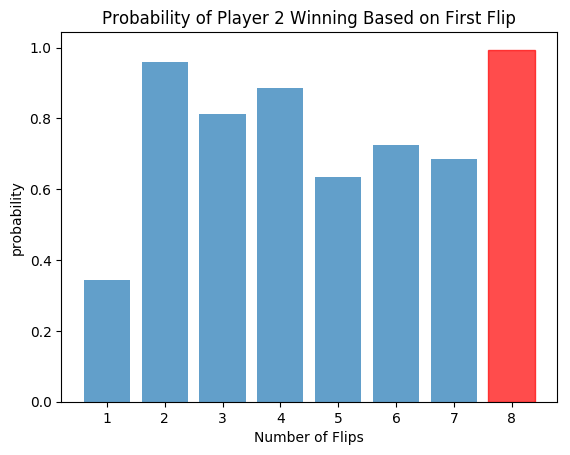

In [8]:
preds = game_ai.predict([np.asarray([[0.0,0.0] + onehot_vector(8, N)]) for N in range(8)])
print preds
plot_preds(preds, 'Probability of Player 2 Winning Based on First Flip')

With the highest value of probability at the 8th position, it looks like it tries to flip 8 coins initially, which yields 128 points with 1/256 probability, which would instantly win the game. 

It is obvious, though, that these probabilities are not very accurate, as the win rate should be roughly 60%. However, these only account for the first of a few hundred moves, so the network isn't trying to fit these values any harder than any other ones, making them more prone to error.

Does this hold up if player 1 is ahead a bit?

[ 0.08885646  0.39257035  0.23592898  0.23587571  0.23701109  0.2840803
  0.39622968  0.92520273]


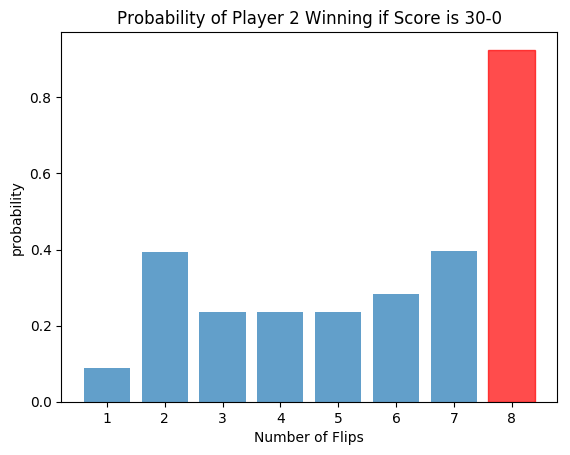

In [9]:
preds = game_ai.predict([np.asarray([[0.3,0.0] + onehot_vector(8, N)]) for N in range(8)])
print preds
plot_preds(preds, 'Probability of Player 2 Winning if Score is 30-0')

Yes, at the point that player 1 has 30 points and player 2 has 0, it will switch to flipping 8 coins,as well. Directionally, this makes sense, as flipping 8 coins is not a bad idea when you are behind, but the probability of 0.925 is way too high.

[ 0.00214306  0.01176638  0.00579521  0.00558263  0.01811657  0.01701191
  0.02407223  0.05771782]


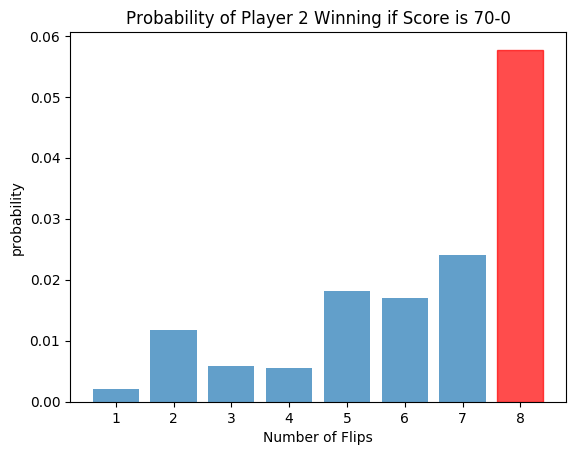

In [10]:
preds = game_ai.predict([np.asarray([[0.7,0.0] + onehot_vector(8, N)]) for N in range(8)])
print preds
plot_preds(preds, 'Probability of Player 2 Winning if Score is 70-0')

When player 1 has 70 points, the only chances of player 2 are winning involve flipping 8 coins, and the probability is actually a bit more realistic this time.

Note that the above probabilities are heavily skewed to conform to the playstyle that would lead the computer to make those moves. That is, the winning probabilities are strongly associated with the probabilities that the AI had when it was more likely to make that move. If a move fell out of favor as the AI was trained, then the probability is more likely to remain low for that move, since the row representing that move will have fewer rows like it as training goes on.


[ 0.99555379  0.99934679  0.99897337  0.99951446  0.99727803  0.99735212
  0.99660122  0.99989069]


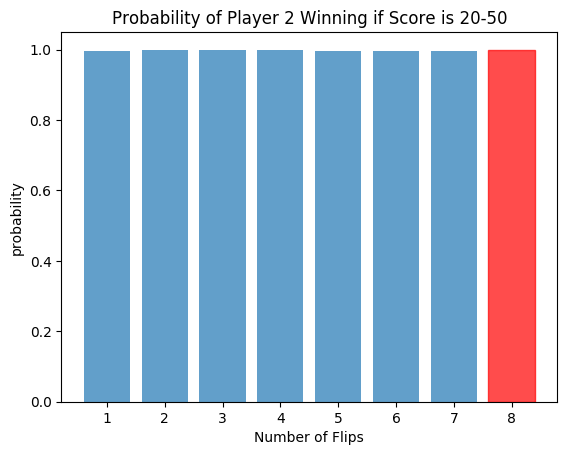

In [11]:
preds = game_ai.predict([np.asarray([[0.2,0.5] + onehot_vector(8, N)]) for N in range(8)])
print preds
plot_preds(preds, 'Probability of Player 2 Winning if Score is 20-50')

Similarly, when player 2 is ahead, the probabilities are skewed towards taking the AI's behavior into account. 
Additionally, many of these states are unlikely, so the probabilties probably don't affect what it does too much.

These probabilities rely too much on the training data, since neural networks tend to fit odd patterns with data that is not very similar to training data. Because there is a strong correlation between what moves the AI makes, statistical inference is not very meaningful when it comes to these probabilities. 

The neural network architecture (number of layers, layer sizes, etc.) also may not be the best, which limits what kind of behavior the network can have.

In this case, the probabilities provide directional guidance for the AI, and *for this specific problem*, reinforcement learning isn't the best way to approach the problem.

# Additional Thoughts

## Reward System

The above game is highly probabilistic, and each individual decision is not worth too much, and the expected value in terms of points of each decision is the same. Because of this, I have no additional "reward" for the algorithm beyond whether a player won or lost. 

In other applications of reinforcement learning, short-term gains are used as reward parameters. If these rewards can be predicted, possibly by a second network (or a partially shared network), they could be factored in to the decisionmaking process.

## Output Realisticness

If the network was trained longer, the probabilities would probably become more realistic. There would need to be a different architecture, as the one I have above is fairly small and can only hold so much information. In the end, the probabilities are dependent on the decisions that the player is going to make (as part of the training process),

